In [65]:
# Se importan las librerías necesarias para el análisis:
# - pandas: manipulación de datos estructurados
# - StandardScaler: estandarización de variables numéricas
# - KMeans: algoritmo de clustering no supervisado
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import re

# Se carga el dataset preprocesado con características musicales desde archivo parquet
df = pd.read_parquet('songs_optimized.parquet')

In [66]:
# Se visualizan las primeras 5 filas del DataFrame para inspeccionar su estructura
df.head()

,Artist(s),song,text,Length,emotion,Genre,Album,Release Date,Key,Tempo,...,Good for Morning Routine,Similar Artist 1,Similar Song 1,Similarity Score 1,Similar Artist 2,Similar Song 2,Similarity Score 2,Similar Artist 3,Similar Song 3,Similarity Score 3
0,!!!,Even When the Waters Cold,Friends told her she was better off at the bot...,03:47,sadness,hip hop,Thr!!!er,29th April 2013,D min,105,...,False,Corey Smith,If I Could Do It Again,0.986061,Toby Keith,Drinks After Work,0.983719,Space,Neighbourhood,0.983236
1,!!!,One Girl / One Boy,"Well I heard it, playing soft From a drunken b...",04:03,sadness,hip hop,Thr!!!er,29th April 2013,A# min,117,...,False,Hiroyuki Sawano,BRE@TH//LESS,0.995409,When In Rome,Heaven Knows,0.990905,Justice Crew,Everybody,0.984483
2,!!!,Pardon My Freedom,"Oh my god, did I just say that out loud? Shoul...",05:51,joy,hip hop,Louden Up Now,8th June 2004,A Maj,121,...,False,Ricky Dillard,More Abundantly Medley Live,0.993176,Juliet,Avalon,0.965147,The Jacksons,Lovely One,0.956752
3,!!!,Ooo,[Verse 1] Remember when I called you on the te...,03:44,joy,hip hop,As If,16th October 2015,A min,122,...,False,Eric Clapton,Man Overboard,0.992749,Roxette,Don't Believe In Accidents,0.991494,Tiwa Savage,My Darlin,0.990381
4,!!!,Freedom 15,[Verse 1] Calling me like I got something to s...,06:00,joy,hip hop,As If,16th October 2015,F min,123,...,False,Cibo Matto,Lint Of Love,0.981610,Barrington Levy,Better Than Gold,0.981524,Freestyle,Its Automatic,0.981415


In [67]:
# Se revisan los tipos de datos de cada columna para identificar columnas numéricas, categóricas o mal tipificadas
df.dtypes

Artist(s)                         category
song                                object
text                                object
Length                              object
emotion                           category
Genre                             category
Album                             category
Release Date                        object
Key                               category
Tempo                                int64
Loudness (db)                       object
Time signature                    category
Explicit                              bool
Popularity                           uint8
Energy                               uint8
Danceability                         uint8
Positiveness                         uint8
Speechiness                          uint8
Liveness                             uint8
Acousticness                         uint8
Instrumentalness                     uint8
Good for Party                        bool
Good for Work/Study                   bool
Good for Re

In [68]:
# Se identifican automáticamente las columnas de tipo booleano
bool_cols = df.select_dtypes(include=['bool']).columns

# Se convierten las variables booleanas a valores numéricos (0 y 1), requeridos para el modelo
df[bool_cols] = df[bool_cols].astype(int)

# Se visualiza una muestra de las columnas booleanas ya transformadas
print(df[bool_cols].head())

   Explicit  Good for Party  Good for Work/Study  \
0         0               0                    0   
1         0               0                    0   
2         0               0                    0   
3         0               0                    0   
4         0               0                    0   

   Good for Relaxation/Meditation  Good for Exercise  Good for Running  \
0                               0                  0                 0   
1                               0                  0                 0   
2                               0                  1                 0   
3                               0                  1                 0   
4                               0                  1                 0   

   Good for Yoga/Stretching  Good for Driving  Good for Social Gatherings  \
0                         0                 0                           0   
1                         0                 0                           0   
2          

In [69]:
# Se normaliza la columna 'Genre' para extraer solo el primer género en caso de múltiples etiquetas
# Esto ayuda a simplificar la categorización y análisis posterior
df['Genre_principal'] = df['Genre'].astype(str).str.lower().str.split(',|/').str[0].str.strip()

In [70]:
# Se visualizan los géneros principales únicos identificados tras la limpieza
df['Genre_principal'].unique()

array(['hip hop', 'jazz', 'indie rock', 'classical', 'rock', 'rap',
       'trance', 'country', 'electronic', 'pop', 'chillout',
       'alternative rock', 'hip-hop', 'punk', 'k-pop', 'metal', 'folk',
       'trap', 'cloud rap', 'reggae', 'industrial', 'soul', 'punk rock',
       'garage rock', 'nu metal', 'experimental', 'blues', 'black metal',
       'drum and bass', 'dance', 'pop rock', 'funk', 'hard rock',
       'heavy metal', 'power metal', 'soundtrack', 'hardcore', 'house',
       'math rock', 'indie', 'melodic death metal', 'synthpop', 'techno',
       'post-punk', 'indie pop', 'post-hardcore', 'lo-fi', 'shoegaze',
       'electropop', 'death metal', 'latin', 'progressive rock',
       'dream pop', 'worship', 'psychedelic rock', 'j-pop', 'doom metal',
       'gospel', 'disco', 'ambient', 'comedy', 'christian', 'metalcore',
       'new wave', 'acoustic', 'progressive metal', 'rnb', 'trip-hop',
       'pop punk', 'dancehall', 'emo', 'dubstep', 'swing', 'thrash metal',
       'bri

In [71]:
# Distribución de frecuencias por género principal
df['Genre_principal'].value_counts()

Genre_principal
hip hop             271314
rock                 69646
pop                  32052
alternative rock     13209
electronic           10730
                     ...  
psychedelic             76
alt-country             56
chillout                48
britpop                 46
reggaeton               10
Name: count, Length: 88, dtype: int64

In [72]:
# Función para convertir una duración en formato 'mm:ss' a segundos
# Se incluye manejo de errores para valores nulos o mal formateados
def convertir_a_segundos(tiempo):
    try:
        minutos, segundos = map(int, tiempo.split(':'))
        return minutos * 60 + segundos
    except:
        return None  # En caso de error, se retorna un valor nulo

# Se aplica la conversión a la columna 'Length' y se crea una nueva columna numérica
df['Duration_sec'] = df['Length'].astype(str).apply(convertir_a_segundos)

# Se elimina la columna original 'Length', ya que ahora contamos con la versión numérica
df.drop(columns=['Length'], inplace=True)

In [73]:
# 1. Eliminación de columnas irrelevantes para el análisis de clustering
# Se remueven columnas relacionadas con metadatos y recomendaciones previas que no aportan al modelo
columns_to_drop = [
    'Similar Song 1', 'Similar Song 2', 'Similar Song 3',
    'Album', 'Release Date', 'text','Similar Artist 1', 
    'Similarity Score 1', 'Similar Artist 2', 
    'Similarity Score 2', 'Similar Artist 3', 
    'Similarity Score 3', 'Key',
]

# Se eliminan solo si existen en el DataFrame, evitando errores en caso de nombres ausentes
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

# Se visualiza la estructura del DataFrame tras la eliminación
print(df.columns)

Index(['Artist(s)', 'song', 'emotion', 'Genre', 'Tempo', 'Loudness (db)',
       'Time signature', 'Explicit', 'Popularity', 'Energy', 'Danceability',
       'Positiveness', 'Speechiness', 'Liveness', 'Acousticness',
       'Instrumentalness', 'Good for Party', 'Good for Work/Study',
       'Good for Relaxation/Meditation', 'Good for Exercise',
       'Good for Running', 'Good for Yoga/Stretching', 'Good for Driving',
       'Good for Social Gatherings', 'Good for Morning Routine',
       'Genre_principal', 'Duration_sec'],
      dtype='object')


In [74]:
# Limpiar nombre con apostrofes
def limpiar_nombre(texto):
    if pd.isnull(texto):
        return ''
    # Pasar a string, minúsculas, quitar espacios extra y signos raros
    texto = str(texto).lower()
    texto = re.sub(r"[^\w\s]", '', texto)       # quitar puntuación
    texto = re.sub(r"\s+", " ", texto).strip()  # quitar espacios extra
    return texto

def preparar_dataframe(df):
    df['song_clean'] = df['song'].apply(limpiar_nombre)
    df['artist_clean'] = df['Artist(s)'].apply(limpiar_nombre)
    df['track_id_clean'] = df['song_clean'] + ' - ' + df['artist_clean']
    
    # Opcional: eliminar duplicados por canción/artista limpios
    df = df.drop_duplicates(subset=['track_id_clean'])

    return df

In [75]:
df = preparar_dataframe(df)

In [76]:
# Se eliminan registros duplicados basados en el nombre de la canción, artista y duración
# Esto evita que se repitan versiones idénticas de una misma canción en el análisis
df = df.drop_duplicates(subset=["song", "Artist(s)", "Duration_sec"])

In [77]:
# Se listan las emociones únicas presentes en la columna 'emotion' (omitiendo valores nulos)
# Esto permite entender cómo se distribuyen las emociones categóricas en el dataset
for e in df['emotion'].dropna().unique():
    print(f"- {e}")

- sadness
- joy
- love
- surprise
- anger
- fear
- True
- thirst
- confusion
- pink
- interest
- Love


In [78]:
df['emotion'].value_counts(dropna=False)

emotion
joy          186769
sadness      154404
anger         94678
fear          25620
love          24969
surprise       4894
True             17
Love              2
pink              2
confusion         1
interest          1
thirst            1
angry             0
Name: count, dtype: int64

In [79]:
# 1. Se crea una copia del DataFrame original para trabajar sobre una versión editable sin afectar los datos base
df_cluster = df.copy()

# 2. Limpieza de la columna 'emotion'
# Se unifican valores inconsistentes o ruidosos que no representan emociones válidas
emotion_map = {
    'love': 'love',
    'Love': 'love',
    'angry': 'anger',
    'true': 'unknown',
    'pink': 'unknown',
    'thirst': 'unknown',
    'confusion': 'unknown',
    'interest': 'unknown'
}

df_cluster['emotion'] = (
    df_cluster['emotion']
    .astype(str)
    .str.strip()
    .str.lower()
    .replace(emotion_map)
    .fillna('unknown')
)


# 3. Codificación one-hot de las emociones para convertirlas en variables binarias
df_cluster = pd.get_dummies(df_cluster, columns=['emotion'])

# Se visualiza la estructura de las columnas de emociones
[col for col in df_cluster.columns if col.startswith('emotion_')]

['emotion_anger',
 'emotion_fear',
 'emotion_joy',
 'emotion_love',
 'emotion_sadness',
 'emotion_surprise',
 'emotion_unknown']

In [80]:
# Se identifican las nuevas columnas booleanas generadas por el one-hot encoding de emociones
bool_cols = df_cluster.select_dtypes(include='bool').columns

# Se transforman estas columnas a tipo entero (0/1), necesario para KMeans
df_cluster[bool_cols] = df_cluster[bool_cols].astype(int)

In [81]:
# Se revisan los tipos de datos finales del DataFrame para verificar la preparación de las variables numéricas
df_cluster.dtypes

Artist(s)                         category
song                                object
Genre                             category
Tempo                                int64
Loudness (db)                       object
Time signature                    category
Explicit                             int32
Popularity                           uint8
Energy                               uint8
Danceability                         uint8
Positiveness                         uint8
Speechiness                          uint8
Liveness                             uint8
Acousticness                         uint8
Instrumentalness                     uint8
Good for Party                       int32
Good for Work/Study                  int32
Good for Relaxation/Meditation       int32
Good for Exercise                    int32
Good for Running                     int32
Good for Yoga/Stretching             int32
Good for Driving                     int32
Good for Social Gatherings           int32
Good for Mo

In [227]:
emotion_cols = [col for col in df_cluster.columns if col.startswith('emotion_')]
df_cluster[emotion_cols].sum()


emotion_anger        94678
emotion_fear         25620
emotion_joy         186769
emotion_love         24971
emotion_sadness     154404
emotion_surprise      4894
emotion_unknown         22
dtype: int64

In [82]:
# Paso 1: Normalizar los valores de la columna 'Genre_principal'
df_cluster['Genre_principal'] = df_cluster['Genre_principal'].astype(str).str.lower().str.strip()

# Paso 2: Función para asignar grupos intermedios de género musical
def asignar_genero_intermedio(g):
    if not isinstance(g, str):
        return 'other'

    g = g.lower().strip()

    # Rock y variantes
    if g in [
        'rock', 'alternative rock', 'classic rock', 'hard rock',
        'indie rock', 'garage rock', 'math rock', 'shoegaze',
        'post-punk', 'grunge', 'britpop', 'pop punk', 'punk', 'punk rock'
    ]:
        return 'rock'

    # Pop y derivados comerciales
    elif g in [
        'pop', 'electropop', 'synthpop', 'pop rock', 'mainstream pop'
    ]:
        return 'pop'

    # Indie pop y dream pop como categoría aparte
    elif g in ['indie pop', 'dream pop']:
        return 'indie pop / dream pop'

    # Hip hop, rap, trap
    elif g in [
        'hip hop', 'hip-hop', 'rap', 'trap', 'emo rap',
        'grime', 'cloud rap'
    ]:
        return 'hip hop / rap'

    # Electrónica bailable (club)
    elif g in [
        'electronic', 'house', 'techno', 'electro', 'trance',
        'edm', 'dance', 'future bass', 'disco', 'dubstep'
    ]:
        return 'electronic (club)'

    # Electrónica relajada
    elif g in [
        'lo-fi', 'chillwave', 'downtempo', 'ambient', 'trip-hop', 'chillout'
    ]:
        return 'chill / downtempo'

    # Experimental, alternativa dura
    elif g in [
        'experimental', 'alternative', 'post-hardcore', 'screamo',
        'industrial', 'emo', 'new wave', 'noise', 'indie', 'hardcore'
    ]:
        return 'experimental / alternativa'

    # Metal y subgéneros
    elif g in [
        'metal', 'heavy metal', 'nu metal', 'deathcore',
        'melodic death metal', 'doom metal', 'thrash metal',
        'progressive metal', 'black metal', 'metalcore', 'power metal',
        'death metal'
    ]:
        return 'metal'

    # Psicodélico y progresivo
    elif g in [
        'psychedelic', 'psychedelic rock', 'progressive rock', 'space rock'
    ]:
        return 'psicodélico / progresivo'

    # Folk, country, americana
    elif g in [
        'folk', 'country', 'alt-country', 'americana', 'acoustic'
    ]:
        return 'folk / country'

    # Jazz, soul, funk, blues
    elif g in [
        'jazz', 'blues', 'soul', 'funk', 'swing'
    ]:
        return 'jazz / soul / funk'

    # R&B moderno
    elif g in [
        'r&b', 'rnb', 'neo soul'
    ]:
        return 'r&b'

    # Clásica, espiritual, bandas sonoras
    elif g in [
        'classical', 'soundtrack', 'worship', 'gospel', 'christian'
    ]:
        return 'clásica / espiritual'

    # Reggae y estilos caribeños
    elif g in [
        'reggae', 'dancehall', 'dub', 'reggaeton'
    ]:
        return 'reggae / caribeño'

    # Géneros latinos
    elif g in ['latin', 'salsa', 'cumbia', 'bachata']:
        return 'latino'

    # Pop asiático
    elif g in ['k-pop', 'j-pop', 'c-pop', 'v-pop', 'mandopop']:
        return 'asian pop'

    # Acústico, soft rock, cantautor
    elif g in ['singer-songwriter', 'soft rock', 'acoustic pop', 'folk pop']:
        return 'acoustic / soft rock'

    # Humor, misceláneo
    elif g in ['comedy', 'novelty']:
        return 'comedy / otros'

    # Otros géneros no contemplados
    else:
        return 'other'

# Paso 3: Aplicar la función al DataFrame
df_cluster['Genre_grupo'] = df_cluster['Genre_principal'].apply(asignar_genero_intermedio)

# Paso 4: Mostrar la distribución final de canciones por grupo
print("Distribución de canciones por grupo de género:")
print(df_cluster['Genre_grupo'].value_counts())


Distribución de canciones por grupo de género:
Genre_grupo
hip hop / rap                 239972
rock                           99275
pop                            42677
jazz / soul / funk             19317
folk / country                 19305
metal                          17019
electronic (club)              15137
experimental / alternativa      8886
clásica / espiritual            7559
reggae / caribeño               6203
indie pop / dream pop           4999
psicodélico / progresivo        3644
chill / downtempo               2296
other                           2021
asian pop                       1360
comedy / otros                   857
r&b                              492
latino                           339
Name: count, dtype: int64


In [83]:
# Codificar la variable 'Genre_grupo' con one-hot encoding (dummies)
df_cluster = pd.get_dummies(df_cluster, columns=['Genre_grupo'], prefix='Genre')

# Mostrar un ejemplo de las columnas creadas para verificar que funcionó
print(df_cluster.filter(like='Genre_').head())

# Revisar el tipo de datos de las columnas dummy generadas
print(df_cluster.filter(like='Genre_').dtypes.value_counts())


  Genre_principal  Genre_asian pop  Genre_chill / downtempo  \
0         hip hop            False                    False   
1         hip hop            False                    False   
2         hip hop            False                    False   
3         hip hop            False                    False   
4         hip hop            False                    False   

   Genre_clásica / espiritual  Genre_comedy / otros  Genre_electronic (club)  \
0                       False                 False                    False   
1                       False                 False                    False   
2                       False                 False                    False   
3                       False                 False                    False   
4                       False                 False                    False   

   Genre_experimental / alternativa  Genre_folk / country  \
0                             False                 False   
1                 

In [84]:
# Convertir columnas booleanas a enteros (0 y 1) si existen
for col in df_cluster.select_dtypes(include='bool').columns:
    df_cluster[col] = df_cluster[col].astype(int)


In [85]:
# Verificar si todas están en int para aplicar en el modelo
df_cluster.dtypes

Artist(s)                           category
song                                  object
Genre                               category
Tempo                                  int64
Loudness (db)                         object
Time signature                      category
Explicit                               int32
Popularity                             uint8
Energy                                 uint8
Danceability                           uint8
Positiveness                           uint8
Speechiness                            uint8
Liveness                               uint8
Acousticness                           uint8
Instrumentalness                       uint8
Good for Party                         int32
Good for Work/Study                    int32
Good for Relaxation/Meditation         int32
Good for Exercise                      int32
Good for Running                       int32
Good for Yoga/Stretching               int32
Good for Driving                       int32
Good for S

In [303]:
emotion_cols = [col for col in df_cluster.columns if col.startswith('Genre_')]
df_cluster[emotion_cols].sum()

Genre_asian pop                       1360
Genre_chill / downtempo               2296
Genre_clásica / espiritual            7559
Genre_comedy / otros                   857
Genre_electronic (club)              15137
Genre_experimental / alternativa      8886
Genre_folk / country                 19305
Genre_hip hop / rap                 239970
Genre_indie pop / dream pop           4999
Genre_jazz / soul / funk             19317
Genre_latino                           339
Genre_metal                          17019
Genre_other                           2021
Genre_pop                            42677
Genre_psicodélico / progresivo        3644
Genre_r&b                              492
Genre_reggae / caribeño               6203
Genre_rock                           99275
dtype: int64

In [86]:
# Ver columnas que no son tipo int o float (posibles problemas)
print(df_cluster.select_dtypes(exclude=['int', 'float']).dtypes)

Artist(s)           category
song                  object
Genre               category
Loudness (db)         object
Time signature      category
Popularity             uint8
Energy                 uint8
Danceability           uint8
Positiveness           uint8
Speechiness            uint8
Liveness               uint8
Acousticness           uint8
Instrumentalness       uint8
Genre_principal       object
song_clean            object
artist_clean          object
track_id_clean        object
dtype: object


In [87]:
df_cluster = df_cluster.drop(columns=['Genre'])
df_cluster = df_cluster.drop(columns=['Genre_principal'])

In [537]:
# 1️ Identificación de columnas generadas por el one-hot encoding de 'Genre_grupo'
# Estas columnas binarizadas se usarán como parte del conjunto de variables explicativas
genre_grupo_cols = [col for col in df_cluster.columns if col.startswith('Genre_')]

# 2️ Identificación de columnas codificadas desde la variable 'emotion'
emotion_cols = [col for col in df_cluster.columns if col.startswith('emotion_')]

# 3️ Definición del conjunto final de variables (features) para el modelo de clustering
# Se incluyen variables acústicas, emocionales, de contexto (actividades) y los géneros codificados
features = [
    'Energy', 'Danceability', 'Tempo',
    'Positiveness', 'Speechiness', 'Liveness',
    'Acousticness', 'Instrumentalness',
    'Duration_sec',
    'Good for Party', 'Good for Work/Study',
    'Good for Relaxation/Meditation', 'Good for Exercise',
    'Good for Running', 'Good for Yoga/Stretching',
    'Good for Driving', 'Good for Social Gatherings',
    'Good for Morning Routine'
] + emotion_cols + genre_grupo_cols


In [538]:
# Verificar si todas las columnas listadas existen en el DataFrame
missing = [col for col in features if col not in df_cluster.columns]

if missing:
    print("Columnas faltantes en df_cluster:", missing)
else:
    print("Todas las columnas existen en df_cluster.")


Todas las columnas existen en df_cluster.


In [552]:
# 1️ Definir columnas acústicas, contexto, emociones y géneros
cols_acusticas = ['Energy', 'Danceability', 'Tempo', 'Positiveness', 'Speechiness',
                  'Liveness', 'Acousticness', 'Instrumentalness', 'Duration_sec']

cols_contexto = ['Good for Party', 'Good for Work/Study', 'Good for Relaxation/Meditation',
                 'Good for Exercise', 'Good for Running', 'Good for Yoga/Stretching',
                 'Good for Driving', 'Good for Social Gatherings', 'Good for Morning Routine']

# 2️ Pesos acústicos según importancia relativa
pesos_acusticos = [
    2.5,  # Energy
    2.0,  # Danceability
    3.0,  # Tempo
    2.0,  # Positiveness
    3.0,  # Speechiness
    2.0,  # Liveness
    3.0,  # Acousticness
    3.0,  # Instrumentalness
    0.5   # Duration_sec
]

# 3️ Pesos emociones ajustados por frecuencia inversa
conteos_emociones = df_cluster[emotion_cols].sum()
pesos_emociones = 1 / (conteos_emociones + 1)
pesos_emociones = pesos_emociones.values.tolist()

# 4️ Pesos contexto uniformes
pesos_contexto = [2.0] * len(cols_contexto)

# 5️ Pesos géneros ajustados por frecuencia inversa
conteos_generos = df_cluster[genre_grupo_cols].sum()
pesos_generos = 1 / (conteos_generos + 1)
pesos_generos = pesos_generos.values.tolist()

# === NORMALIZACIÓN POR BLOQUES ===

# Peso total a repartir entre bloques
peso_total = 10.0
peso_acustico = 2.5
peso_contexto = 2.5
peso_emocional = 2.0
peso_genero = 3.0

# Normalización de cada bloque para que su suma total coincida con su peso objetivo
pesos_acusticos = np.array(pesos_acusticos)
pesos_acusticos = (pesos_acusticos / pesos_acusticos.sum()) * peso_acustico

pesos_contexto = np.array(pesos_contexto)
pesos_contexto = (pesos_contexto / np.sum(pesos_contexto)) * peso_contexto

pesos_emociones = np.array(pesos_emociones)
pesos_emociones = (pesos_emociones / np.sum(pesos_emociones)) * peso_emocional

pesos_generos = np.array(pesos_generos)
pesos_generos = (pesos_generos / np.sum(pesos_generos)) * peso_genero

# 6️ Concatenar todos los pesos en orden correcto para el vector de características
pesos = np.concatenate([pesos_acusticos, pesos_contexto, pesos_emociones, pesos_generos])



In [553]:
assert len(pesos) == len(features), f"Error: pesos ({len(pesos)}) y features ({len(features)}) no coinciden"
print("Vector de pesos construido correctamente.")

Vector de pesos construido correctamente.


In [554]:
# Revisar si alguna de las columnas en `features` no es numérica
non_numeric = df_cluster[features].select_dtypes(exclude=['int', 'float', 'uint8']).columns
print("Columnas no numéricas en features:", list(non_numeric))


Columnas no numéricas en features: []


In [610]:
# 4️ Escalamiento de las variables seleccionadas
# Se estandariza la escala de los datos utilizando StandardScaler para mejorar la performance del modelo KMeans
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[features])
X_ponderado = X_scaled * pesos

# 5️ Entrenamiento del modelo de clustering KMeans con 190 clusters
# El número de clusters puede ajustarse según evaluación exploratoria
kmeans = KMeans(n_clusters=150, n_init=10, random_state=42)
df_cluster['cluster'] = kmeans.fit_predict(X_ponderado)

# 6️ Función de recomendación de canciones basada en cluster
# Selecciona canciones aleatorias dentro del cluster especificado
def recomendar_canciones(df, cluster_id, n=10):
    canciones = df[df['cluster'] == cluster_id]
    return canciones[['song', 'Artist(s)', 'cluster']].sample(n=min(n, len(canciones)))

In [611]:
#EjEMPLO de cluster
recomendar_canciones(df_cluster, cluster_id=12, n=10)

,song,Artist(s),cluster
166134,Right Now,"Fort Minor,Black Thought,Styles Of Beyond",12
150805,Geography,Enjoy,12
545836,Wild Wild Woman,Your Smith,12
181332,Stand,Glee Cast,12
504977,The Truth About Men,Tracy Byrd,12
188094,Dope Boys,Gucci Mane,12
65293,Cousin,Boyzvoice,12
462869,No-go Showboat,The Beach Boys,12
298963,Its a Girl Party,Mackz,12
94720,Blame Game,Clinton Fearon,12


In [612]:
# Función principal de recomendación.

def recomendar_por_grupo(df_cluster, song_tuples, features, scaler, kmeans, pesos, n=10, min_cluster_size=100):
    """
    Recomienda canciones similares a un grupo de entrada entregado por el usuario,
    utilizando el perfil acústico-emocional promedio del grupo base.

    Parámetros:
    - df_cluster: DataFrame con todas las canciones, sus atributos (features), y cluster asignado.
    - song_tuples: Lista de tuplas (nombre_canción, nombre_artista) como input del usuario.
    - features: Lista de columnas numéricas (features acústicas, contextuales, emocionales, etc.) para comparación.
    - scaler: Objeto de escalado (StandardScaler, MinMaxScaler, etc.) ya ajustado.
    - kmeans: Modelo de clustering KMeans ya entrenado.
    - pesos: Vector NumPy con los pesos asociados a cada feature.
    - n: Número de canciones a recomendar (por defecto 10).
    - min_cluster_size: Tamaño mínimo del cluster considerado válido para recomendar.

    Retorna:
    - DataFrame con canciones recomendadas más cercanas al perfil promedio del input.
    """

    # 1. Normaliza títulos y artistas (input + dataset) para comparación robusta
    song_tuples = [(s.lower().strip(), a.lower().strip()) for s, a in song_tuples]
    df_cluster['song_normalized'] = df_cluster['song'].str.lower().str.strip()
    df_cluster['artist_normalized'] = df_cluster['Artist(s)'].str.lower().str.strip()

    # 2. Selecciona canciones del dataset que coincidan con el título exacto
    #     y contengan al artista indicado (útil para colaboraciones)
    grupo = df_cluster[
        df_cluster.apply(
            lambda row: any(
                (row['song_normalized'] == s and s_artista in row['artist_normalized'])
                for s, s_artista in song_tuples
            ),
            axis=1
        )
    ]

    # 2.1 Muestra advertencia si hay canciones del input que no fueron encontradas en el dataset
    canciones_input = set(song_tuples)
    canciones_encontradas = set([
        (row['song_normalized'], s_artista)
        for _, row in grupo.iterrows()
        for s, s_artista in song_tuples
        if row['song_normalized'] == s and s_artista in row['artist_normalized']
    ])
    no_encontradas = canciones_input - canciones_encontradas

    if no_encontradas:
        print("Canciones NO encontradas en el dataset (nombre + artista):")
        for song, artist in no_encontradas:
            print(f" - '{song}' — {artist}")
        print("\n Solo se usaron las canciones encontradas para la recomendación.\n")

    # 2.2 Si no se encontró ninguna canción válida, se detiene el proceso
    if grupo.empty:
        raise ValueError("No se encontraron canciones válidas en el DataFrame. Verifica nombre y artista.")

    # 3. Escala y pondera las features del grupo base
    grupo_scaled = scaler.transform(grupo[features]) * pesos

    # 4. Calcula el vector promedio del grupo base
    promedio = grupo_scaled.mean(axis=0).reshape(1, -1)

    # 5. Ordena todos los clusters por cercanía al vector promedio
    distancias_clusters = np.linalg.norm(kmeans.cluster_centers_ - promedio, axis=1)
    clusters_ordenados = np.argsort(distancias_clusters)

    # 6. Filtra clusters que tengan al menos 'min_cluster_size' canciones
    cluster_counts = df_cluster['cluster'].value_counts()
    clusters_validos = cluster_counts[cluster_counts >= min_cluster_size].index.tolist()

    # 7. Detecta los 3 géneros predominantes en el grupo base para filtrar luego
    columnas_genero_dummy = [col for col in df_cluster.columns if col.startswith('Genre_')]
    if not columnas_genero_dummy:
        raise ValueError("No se encontraron columnas dummy de género (prefijo 'Genre_').")

    suma_generos = grupo[columnas_genero_dummy].sum().sort_values(ascending=False)
    generos_deseados = suma_generos.head(3).index.tolist()

    # 8. Busca el primer cluster válido y cercano que tenga canciones con géneros similares
    cluster_predicho = None
    candidatos = pd.DataFrame()

    for cid in clusters_ordenados:
        if cid not in clusters_validos:
            continue

        # Filtra canciones del cluster, excluyendo las del grupo base
        subset = df_cluster[
            (df_cluster['cluster'] == cid) &
            (~df_cluster.apply(
                lambda row: any(
                    (row['song_normalized'] == s and s_artista in row['artist_normalized'])
                    for s, s_artista in song_tuples
                ),
                axis=1
            ))
        ].copy()

        if len(subset) == 0:
            continue

        # Filtra solo canciones que compartan algún género con el grupo base
        filtro_genero = subset[generos_deseados].sum(axis=1) > 0
        subset = subset[filtro_genero]

        # Si hay candidatos válidos, se guarda ese cluster y se detiene la búsqueda
        if len(subset) > 0:
            cluster_predicho = cid
            candidatos = subset
            break

    # Si no se encontró ningún cluster adecuado, se notifica
    if cluster_predicho is None or candidatos.empty:
        raise ValueError("No se encontró un cluster cercano con canciones y géneros similares.")

    # 9. Escala y pondera los candidatos del cluster elegido
    candidatos_scaled = scaler.transform(candidatos[features]) * pesos

    # 10. Calcula la distancia de cada candidato al vector promedio del grupo base
    distancias = np.linalg.norm(candidatos_scaled - promedio, axis=1)
    candidatos['distancia_perfil'] = distancias

    
    # 11. Ordena por cercanía al perfil promedio y obtiene más de n para el filtro de artista
    recomendaciones = candidatos.sort_values(by='distancia_perfil').head(min(n, len(candidatos)))

    return recomendaciones[['song', 'Artist(s)', 'cluster', 'distancia_perfil']]


In [613]:
# EJ1
mis_canciones2 = [
    ('1979', 'The Smashing Pumpkins'),
    ('Hard to explain', 'The Strokes'),
    ('This charming man', 'The Smiths'),
    ('Salad days', 'Mac DeMarco'),
    ('Killing an arab', 'The Cure'),
    ('Just like heaven', 'The Cure'),
]

recomendar_por_grupo(df_cluster, mis_canciones2, features, scaler, kmeans, pesos, n=10)

,song,Artist(s),cluster,distancia_perfil
475349,April Skies,The Jesus and Mary Chain,30,0.369945
516253,Dreamer,Uriah Heep,30,0.371525
378582,Swan Lake,Public Image Ltd.,30,0.374682
441487,Sookie Sookie,Steppenwolf,30,0.381004
180412,Kill the Sexplayer,Girls Against Boys,30,0.381514
207109,Cry to Me,IDLES,30,0.388939
460863,Oriole,The Afghan Whigs,30,0.390975
511134,Fever,Two Door Cinema Club,30,0.404813
19205,Artifact,Allah-Las,30,0.407556
115954,Me Time,De Staat,30,0.407835


In [614]:
# EJ2
songs = [
    ('Exchange', 'Bryson Tiller'),
    ('Right My Wrongs', 'Bryson Tiller'),
    ('Let Me Explain', 'Bryson Tiller'),
    ('Break From Toronto', 'Partynextdoor'),
    ('Next to you', 'Bryson Tiller'),
]

recomendar_por_grupo(df_cluster, songs, features, scaler, kmeans, pesos, n=10)

,song,Artist(s),cluster,distancia_perfil
163019,Hateful,FLAVIA,77,0.253934
518710,Selfish,Vedo,77,0.267013
128023,Pick These Hoes Apart,"DJ Khaled,Kodak Black,Jeezy,French Montana",77,0.268808
204430,Sun Goddess,Hurt Everybody,77,0.269381
530450,Melatonin,"WHATUPRG,350",77,0.270056
433471,Curve,SoMo,77,0.271014
43772,Array of Light,Bears In Trees,77,0.271363
242618,Hell Yeah,"Juelz Santana,August Alsina",77,0.272444
164067,Roundtown,FLOHIO,77,0.272559
86118,Cause Im Gettin Money,Chief Keef,77,0.272811


In [615]:
# EJ3
songs2 = [
    ('Exchange', 'Bryson Tiller'),
    ('Right My Wrongs', 'Bryson Tiller'),
    ('Let Me Explain', 'Bryson Tiller'),
    ('Back to Sleep', 'Chris Brown'),
    ('Break from Toronto', 'PARTYNEXTDOOR'),
    ('Persian Rugs', 'PARTYNEXTDOOR'),
    ('Tempo', 'Chris Brown'),
    ('Say It', 'Tory Lanez'),
    ('Overtime', 'Bryson Tiller'),                      
    ('Back to Love', 'Chris Brown'),                    
    ('Belong to the City', 'PARTYNEXTDOOR'),            
    ('With You', 'Chris Brown'),                        
    ('Blessed', 'Daniel Caesar'),                                                                         
    ('Sure Thing', 'Miguel'),                           
    ('Insecure', 'Brent Faiyaz'),
    ('Do Not Disturb', 'Drake'),
    ('Still Think About You', 'A Boogie Wit Da Hoodie')
]

recomendar_por_grupo(df_cluster, songs2, features, scaler, kmeans, pesos, n=10)

,song,Artist(s),cluster,distancia_perfil
1558,Come Over,112,77,0.453576
62923,BrokenTrees,BONES,77,0.462231
350031,Better,OG Maco,77,0.474825
228922,So Gone What My Mind Says,"Jill Scott,Paul Wall",77,0.474934
63530,Apex Predator,"BoofPaxkMooky,Yung Brando",77,0.477722
267931,Stay the Night,Kyle Dion,77,0.478454
205443,Give Me Something,IAMDDB,77,0.478661
436172,Devil In a Red Dress,SpaceMan Zack,77,0.478716
222224,I Think Im Sick,Jaxxon D. Silva,77,0.481222
190415,Process,H.E.R.,77,0.482597


In [616]:
# EJ4
songs_5 = [
    ('Only Your Sins Know', 'Subterranean Street Society'),
    ('Moonlight', 'XXXTENTACION'),
    ('Cross My Heart', 'Nezzy'),
    ('Youth', 'Daughter'),
    ('Night Swim', 'Josef Salvat')
]

recomendar_por_grupo(df_cluster, songs_5, features, scaler, kmeans, pesos, n=10)

,song,Artist(s),cluster,distancia_perfil
181367,Time After Time,Glee Cast,107,0.603931
72617,I'll Never Fall In Love Again,"Burt Bacharach,Elvis Costello",107,0.605499
236340,Bloodsuckers,Johnny Hollow,107,0.605534
300164,Toxic,"Maeta,BEAM",107,0.608377
329301,Follow Me,"Moxie Raia,Wyclef Jean",107,0.610248
139976,Mutombo,Dwn2earth,107,0.610286
237948,Get This Right Outtake,"Jonathan Groff,Original Broadway Cast of Hamilton",107,0.611011
502657,With You,Tony Terry,107,0.611641
479655,Wet Cement,The Morning Benders,107,0.611652
10837,Listen My Brother,Adeaze,107,0.611987


In [617]:
# EJ5
songs_10 = songs_5 + [
    ('Airport Bar', 'goodboy noah'),
    ('Let Me Down Slowly', 'Alec Benjamin'),
    ('Lost', 'Frank Ocean'),
    ('Lucid Dreams', 'Juice WRLD'),
    ('Night Shift', 'Lucy Dacus')
]

recomendar_por_grupo(df_cluster, songs_10, features, scaler, kmeans, pesos, n=10)

,song,Artist(s),cluster,distancia_perfil
237948,Get This Right Outtake,"Jonathan Groff,Original Broadway Cast of Hamilton",107,0.616608
548263,Since We Lost Yall,"Z-Ro,Krayzie Bone",107,0.620666
274105,Question,"Lauv,Travis Mills",107,0.621522
252796,Better Me,"Keith Sweat,Keyshia Cole",107,0.622022
271256,Its You - Dreaming,Lady Zamar,107,0.624318
443307,Vacation,Still Woozy,107,0.625702
379413,Baby Doll,"PZR,Arcanjo Beat",107,0.626011
458074,Free Mind,Tems,107,0.626662
375226,All The World Loves Lovers,Prefab Sprout,107,0.631160
453920,Distant,"Tate McRae,Sean Lew",107,0.631190


In [618]:
# EJ6
songs_20 = songs_10 + [
    ('Falling', 'Harry Styles'),
    ('Cigarette Daydreams', 'Cage The Elephant'),
    ('Drew Barrymore', 'SZA'),
    ('I Need My Girl', 'The National'),
    ('Unfucktheworld', 'Angel Olsen'),
    ('505', 'Arctic Monkeys'),
    ('I Know The End', 'Phoebe Bridgers'),
    ('Dead To Me', 'Kali Uchis'),
    ('Someone You Loved', 'Lewis Capaldi'),
    ('The Night We Met', 'Lord Huron')
]

recomendar_por_grupo(df_cluster, songs_20, features, scaler, kmeans, pesos, n=10)

,song,Artist(s),cluster,distancia_perfil
421508,Lust,Shreea Kaul,107,0.477497
341325,Harry Takes Drugs on the Weekend,Nick Murphy,107,0.483176
135669,Honest,Drake,107,0.484832
232115,The City,Joe Purdy,107,0.489836
531491,Family First,"Whitney Houston, Cissy Houston & Dionne Warwic...",107,0.489917
408358,BOYS,Sam Rui,107,0.490110
17607,Indigo,Alice Gray,107,0.490286
146626,Goodbye Yellow Brick Road,Elton John,107,0.490470
146741,Goodbye,Elton John,107,0.490470
203561,Say My Name,Hozier,107,0.490629


In [619]:
# EJ7
songs_conflict = [
    ('Stronger', 'Kanye West'),
    ('Everybody Dies In Their Nightmares', 'XXXTENTACION'),
    ('Toxic', 'Britney Spears'),
    ('drivers license', 'Olivia Rodrigo'),
    ('Jealous', 'Labrinth'),
    ('Power', 'Kanye West'),                    
    ('Let Her Go', 'Passenger'),    
    ('Goosebumps', 'Travis Scott'),      
    ('Electric Feel', 'MGMT'),           
    ('Take Me To Church', 'Hozier')      
]

recomendar_por_grupo(df_cluster, songs_conflict, features, scaler, kmeans, pesos, n=10)

,song,Artist(s),cluster,distancia_perfil
510030,A Method,TV On The Radio,64,0.664442
224344,Who Needs You,Jeannie Seely,64,0.671244
306338,With You,"Marsha Ambrosius,Ne-Yo",64,0.673093
73160,Descending,"Butch Walker,Ashley Monroe",64,0.674891
131713,Help,Dolly Parton,64,0.676325
15955,Breathe Slow,Alesha Dixon,64,0.676455
88751,Safe And Sound,Chris Cornell,64,0.676827
41856,I Cant Wait,Bars and Melody,64,0.677871
323482,When the Machine Starts,Missy Higgins,64,0.678104
15393,Sweet Soul,alayna,64,0.678292


In [620]:
# EJ8
songs_soft_emotional = [
    ('Heather', 'Conan Gray'),
    ('IDK You Yet', 'Alexander 23'),
    ('All I Want', 'Kodaline'),
    ('Falling', 'Harry Styles'),
    ('Forever', 'Lewis Capaldi'),
    ('Let Her Go', 'Passenger'),
    ('July', 'Noah Cyrus')
]

recomendar_por_grupo(df_cluster, songs_soft_emotional, features, scaler, kmeans, pesos, n=10)

,song,Artist(s),cluster,distancia_perfil
1340,Silhouette of a Life,10 Years,102,0.864424
473981,Down River,The Hollies,102,0.864888
34440,Colorblind,Aura Dione,102,0.866217
181110,Smile Cover of Charlie Chaplin Song,Glee Cast,102,0.866301
131504,Hard Candy Christmas,Dolly Parton,102,0.867169
333513,Killing Me Softly with His Song,Nancy Sinatra,102,0.867211
212718,Snowman,Isak Danielson,102,0.867518
252690,Summer Snow,Keith Green,102,0.867725
163513,Forever - Stripped,FLETCHER,102,0.868348
90684,All That Matters,Christina Perri,102,0.868432


In [621]:
# EJ9
songs_metal_core = [
    ('Duality', 'Slipknot'),
    ('Bodies', 'Drowning Pool'),
    ('Bleed It Out', 'Linkin Park'),
    ('Break Stuff', 'Limp Bizkit'),
    ('Fight Music', 'D12'),
    ('Coming Undone', 'Korn')
]

recomendar_por_grupo(df_cluster, songs_metal_core, features, scaler, kmeans, pesos, n=10)


,song,Artist(s),cluster,distancia_perfil
416442,Wont Look Back,"SEU Worship,David Ryan Cook",0,0.491430
191678,Overthinking,Hands Like Houses,0,0.504952
277827,Pheromone Cvlt,letlive.,0,0.506138
402146,Donna,Rubblebucket,0,0.507269
536813,Filthy,WSTR,0,0.507290
273014,Andy,Last Dinosaurs,0,0.508901
445204,Clash of the Titans,"Styles Of Beyond,Grant Mohrman",0,0.509755
110926,Jesus I Was Evil,Darcy Clay,0,0.509990
549354,If Youre Looking for Your Knife...I Think My B...,zebrahead,0,0.512082
423891,Candle Wax,Sincere Engineer,0,0.512374


In [622]:
# EJ 10
songs_high_energy = [
    ('24K Magic', 'Bruno Mars'),
    ('Juice', 'Lizzo'),
    ('Shut Up and Dance', 'WALK THE MOON'),
    ('Summer', 'Calvin Harris'),
    ('Blinding Lights', 'The Weeknd'),
    ('Electric Feel', 'MGMT'),
    ('Good as Hell', 'Lizzo'),
    ('Treasure', 'Bruno Mars'),
    ('Feel It Still', 'Portugal. The Man'),
    ('Shake It Off', 'Taylor Swift')
]



recomendar_por_grupo(df_cluster, songs_high_energy, features, scaler, kmeans, pesos, n=10)

,song,Artist(s),cluster,distancia_perfil
250743,Midnight Sun,Kate Boy,0,0.711973
12035,Wickedness,Aesthetic Perfection,0,0.714189
220363,Faster,Janelle Monáe,0,0.716139
237753,X,"Jonas Brothers,KAROL G",0,0.716396
350209,Found My Place,"Oh, Hush!,Jeff Lewis",0,0.716457
250076,Straight West,Kasket Club,0,0.716577
291080,Stand By CWC19,"LORYN,Rudimental",0,0.716601
447178,Greenhands,Sundara Karma,0,0.716754
152571,Tell the World,Eric Hutchinson,0,0.716887
299402,Stupid Girl,Madeline Juno,0,0.716933


In [623]:
songs_alegres_espanol = [
    ('F.L.Y.', 'Daddy Yankee'),
    ('Havana Remix', 'Daddy Yankee'),
    ('Alone', 'Romeo santos'),
    ('La Luna', 'Jay Wheeler')
]

recomendar_por_grupo(df_cluster, songs_alegres_espanol, features, scaler, kmeans, pesos, n=10)


,song,Artist(s),cluster,distancia_perfil
160548,Here I Come,Fergie,110,0.928544
155505,Scarecrows,Evil Pimp,110,0.929287
72525,Dedicated To My Haters,"Burna Boy,Seyi Vibez",110,0.929864
339653,You And I,New Hope Club,110,0.930887
184744,Florets,Grace VanderWaal,110,0.931257
22132,Love Em Leave Em,"Amindi,Kari Faux",110,0.931525
300046,Who I Am,"Mads Veslelia,Zoe Soul",110,0.932836
480904,Whos Gonna Rock You,The Nolans,110,0.935196
431123,Oh La La,"Sneakbo,Dappy",110,0.937216
410522,Non Living Thing,"Sarkodie,Oxlade",110,0.937463


In [624]:
solitaria1 = [('Hand Of Blood', 'Bullet For My Valentine')]

recomendar_por_grupo(df_cluster, solitaria1, features, scaler, kmeans, pesos, n=10)

,song,Artist(s),cluster,distancia_perfil
515640,Genocide,Unwritten Law,45,0.121426
72098,Just Another Star,Bullet For My Valentine,45,0.125193
494706,Phoenix Ignition,Thrice,45,0.126092
72089,End of Days,Bullet For My Valentine,45,0.127031
321820,3 S,Mindless Self Indulgence,45,0.129007
321813,Panty Shot,Mindless Self Indulgence,45,0.129015
321915,Adios Amigos,Mindless Self Indulgence,45,0.129015
60767,Sunshine Rock,Bob Mould,45,0.132619
395587,Halfway There,Rise Against,45,0.133333
6955,Born a Wise Man,A Wilhelm Scream,45,0.133490


In [625]:
solitaria2 = [('Next To You', 'Bryson Tiller')]

recomendar_por_grupo(df_cluster, solitaria2, features, scaler, kmeans, pesos, n=10)

,song,Artist(s),cluster,distancia_perfil
32358,God Must Be A Lonely Man,Ashworth,77,0.100887
419615,Lonely,"Shawn Mendes,Justin Bieber",77,0.112775
351050,Boulevard of Smoke n Cheese,Ole 60,77,0.128122
509360,Yeah X3,"TTO K.T.,Trippie Redd",77,0.131745
354383,He Was Only Sixteen,Original God,77,0.137056
436755,Dap You Up,Speaker Knockerz,77,0.138154
549591,Wrong Decision,Zell,77,0.139546
281454,Focus on Me,Lil Mosey,77,0.141804
528372,Take My Hand,Wayne Toups,77,0.145605
244794,Smile,Jussie Smollett,77,0.146481


In [626]:
# EJ2
songs3 = [
    ('Tek It', 'Cafuné'),
    ('Sparks', 'Coldplay'),
    ('I Wanna Be Yours', 'Arctic Monkeys'),
    ('Swim', 'Chase Atlantic'),
    ('Slow Down', 'Chase Atlantic'),
    ('PILLOWTALK', 'ZAYN'),
    ('Die For You', 'The Weeknd'),
    ('Count on Me', 'Bruno Mars')
]

recomendar_por_grupo(df_cluster, songs3, features, scaler, kmeans, pesos, n=10)


,song,Artist(s),cluster,distancia_perfil
445761,Only Your Sins Know,Subterranean Street Society,64,0.561227
203551,Sunlight,Hozier,64,0.561471
189549,Dear Friend,"Guordan Banks,Sonyae Elise",64,0.563857
46019,The Wolves,Ben Howard,64,0.563973
101131,Goodnight La,Counting Crows,64,0.564312
23825,The New Saint Jude,Andrew Bird,64,0.565917
109143,Robots,Dan Mangan,64,0.566883
31334,Liable for Tragedy,Artifex Pereo,64,0.567038
201259,Not Abel,Hop Along,64,0.567109
234530,Come Back to Bed,John Mayer,64,0.568856


In [627]:
# EJ3
songs4 = [
    ('Learn to Fly', 'Foo Fighters'),
    ('Runaway', 'Bon Jovi'),
    ('Linger', 'The Cranberries'),
    ('Country House', 'Blur'),
    ('Cry', 'Cigarettes After Sex'),
    ('Sweet', 'Cigarettes After Sex'),
]

recomendar_por_grupo(df_cluster, songs4, features, scaler, kmeans, pesos, n=10)


,song,Artist(s),cluster,distancia_perfil
23130,Distant Satellites,Anathema,72,0.217338
355246,Passionate Turn,Ought,72,0.251313
87140,Fly at Night,Chilliwack,72,0.261132
505958,How Many Hearts,Travis,72,0.264006
472581,Better Half,The Get Up Kids,72,0.264866
382778,Knives Out,Radiohead,72,0.268288
490773,Doctor Jimmy,The Who,72,0.281183
529069,Captain Fantasy,Ween,72,0.305660
368634,Nothing Was Stolen Love Me Foolishly,Phosphorescent,72,0.312535
42678,The Sun,Baxter Dury,72,0.323154


In [628]:
songs5 = [
    ('PRBLMS', '6LACK'),
    ('Free', '6LACK'),
    ('To My Bed', 'Chris Brown'),
    ('Teenage Fever', 'Drake'),
    ('Birthday Sex', 'Jeremih'),
]

recomendar_por_grupo(df_cluster, songs5, features, scaler, kmeans, pesos, n=10)

,song,Artist(s),cluster,distancia_perfil
33458,Sleep Apnea,"Atmosphere,Slug,Ant",134,0.302397
89065,Perfect,Chris Miles,134,0.303382
548544,Why,Zach Herron,134,0.307151
516479,There Goes My Baby,USHER,134,0.310849
320404,Savage,MIKExANGEL,134,0.314455
135610,Heat of the Moment,Drake,134,0.317116
20460,Superstar,"AlunaGeorge,Cosmo,Peder Losnegård",134,0.320049
124330,CONTRABAND.,Die Mondez,134,0.320958
180021,Dean Gaffney,Ginny Blackmore,134,0.321608
494172,Fire,"Thouxanbanfauni,Black Kray",134,0.321926


In [629]:
songs6 = [
    ('Another Day in Paradise', 'Phil Collins'),
    ('In The Air Tonight', 'Phil Collins'),
    ("You Cant Hurry Love", 'Phil Collins'),  
]

recomendar_por_grupo(df_cluster, songs6, features, scaler, kmeans, pesos, n=10)

,song,Artist(s),cluster,distancia_perfil
80775,Another One of Those Days,Cavetown,64,0.976775
88042,Grass Aint Greener,Chris Brown,64,0.977505
88081,Heartbreak on a Full Moon,Chris Brown,64,0.977540
60128,Baby Stop Crying,Bob Dylan,64,0.983619
34879,Control,Autoheart,64,0.983864
339700,Valentine Girl,New Kids On The Block,64,0.984463
346626,It's Gonna Be,Norah Jones,64,0.985072
367446,Dont Let Him Steal Your Heart Away,Phil Collins,64,0.985103
53245,Loneliness,Birdy,64,0.987829
22546,Little Town,Amy Grant,64,0.988642


In [630]:
songs7 = [
    ('Hold On', 'Limp Bizkit'),
    ('Would?', 'Alice in Chains'),
    ('Paranoid', 'Black Sabbath'),
    ('Back in Black', 'AC/DC'),
    ('Master of Puppets', 'Metallica')
]

recomendar_por_grupo(df_cluster, songs7, features, scaler, kmeans, pesos, n=10)

,song,Artist(s),cluster,distancia_perfil
541997,Poison In Your Veins,Yngwie Malmsteen,116,0.162818
185609,Hey Jude,Grateful Dead,116,0.172912
429255,Happy Together,Slothrust,116,0.177687
463647,Whatever,The Beths,116,0.187582
186853,Light My Love,Greta Van Fleet,116,0.187624
364828,All Your Sins,Pentagram,116,0.189308
86750,Cameo,Childhood,116,0.190833
542050,In The Dead Of Night,Yngwie Malmsteen,116,0.192377
340943,All Tomorrow's Parties,Nick Cave & The Bad Seeds,116,0.210852
17322,Elected,Alice Cooper,116,0.211018


In [631]:
# Generar csv para ver la distribución en los clusters
df_cluster['cluster'].value_counts().sort_index().to_csv("clusters_recuento190.csv")

In [632]:
from sklearn.utils import resample  # Importa una función para tomar muestras aleatorias del dataset
from sklearn.metrics import silhouette_score

#  Paso 1: Tomar una muestra aleatoria del dataset escalado
# Debido a que calcular el silhouette score en los 600.000+ registros es muy costoso,
# se toma una muestra representativa de 100.000 observaciones.
X_sample = resample(X_scaled, n_samples=100000, random_state=42)

#  Paso 2: Evaluar múltiples valores de k (número de clusters) usando silhouette score
# Se prueba con valores de k desde 5 hasta 45 (inclusive), en incrementos de 5.
for k in range(210, 310, 10):
    # Entrena un modelo KMeans con el número de clusters actual
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    
    # Ajusta el modelo a la muestra y obtiene las etiquetas de cluster para cada punto
    labels = model.fit_predict(X_sample)
    
    # Calcula el silhouette score, que mide la calidad del clustering (valores cercanos a 1 son mejores)
    score = silhouette_score(X_sample, labels)
    
    # Imprime el valor de k y su correspondiente silhouette score
    print(f'k={k}, silhouette score={score:.3f}')


k=210, silhouette score=0.186
k=220, silhouette score=0.184
k=230, silhouette score=0.186
k=240, silhouette score=0.187
k=250, silhouette score=0.189
k=260, silhouette score=0.191
k=270, silhouette score=0.188
k=280, silhouette score=0.186
k=290, silhouette score=0.184
k=300, silhouette score=0.187


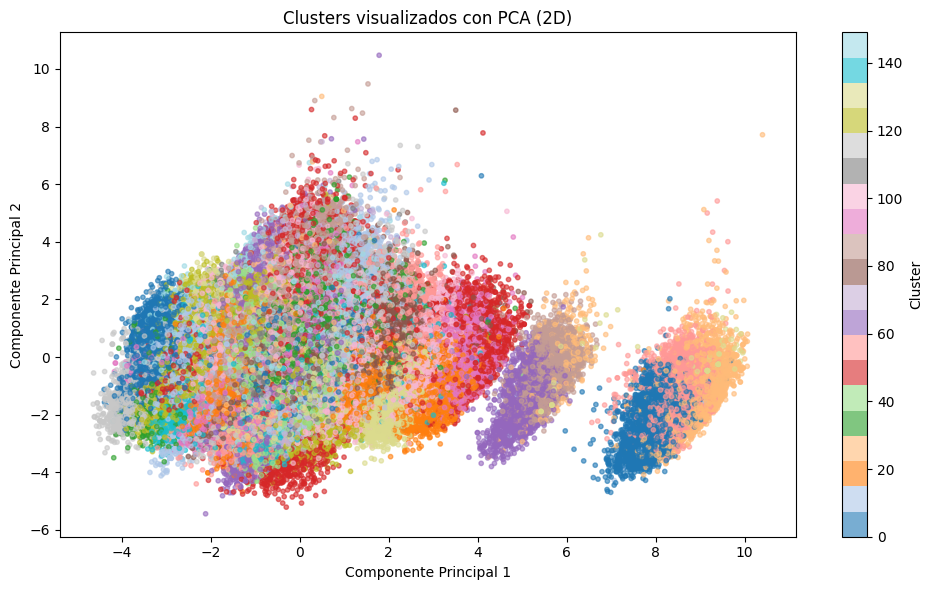

In [633]:
# PCA visual de todos los clusters
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_cluster['cluster'], cmap='tab20', s=10, alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title("Clusters visualizados con PCA (2D)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.tight_layout()
plt.show()

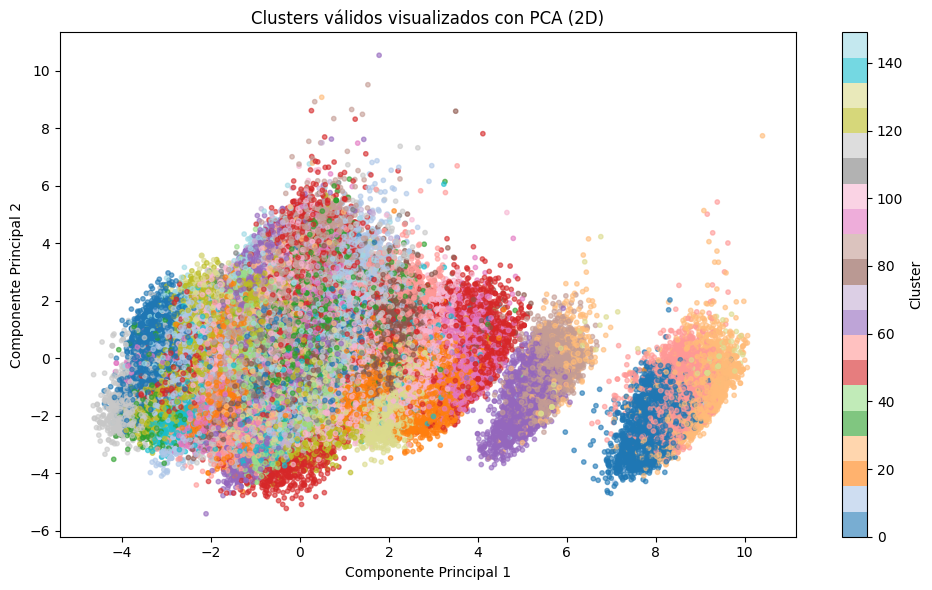

In [634]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Calcular el conteo de canciones por cluster
cluster_counts = df_cluster['cluster'].value_counts()

# Definir umbral mínimo y obtener clusters válidos
min_cluster_size = 100
clusters_validos = cluster_counts[cluster_counts >= min_cluster_size].index.tolist()

# Filtrar el DataFrame original con solo clusters válidos
df_filtrado = df_cluster[df_cluster['cluster'].isin(clusters_validos)]

# Escalar solo las features del subset filtrado
X_filtrado = df_filtrado[features]
X_filtrado_scaled = scaler.transform(X_filtrado)

# Luego aplica PCA
X_pca = pca.fit_transform(X_filtrado_scaled)

# Crear el gráfico
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=df_filtrado['cluster'],
    cmap='tab20',
    s=10,
    alpha=0.6
)
plt.colorbar(scatter, label='Cluster')
plt.title("Clusters válidos visualizados con PCA (2D)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.tight_layout()
plt.show()
